In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os
import keras_tuner as kt
import keras as k
import numpy as np
import argparse
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
#import os
print(os.listdir("/gdrive/My Drive/Kidney_Cancer/Kidney Cancer"))

['Normal', 'Tumor']


In [ ]:
DATADIR = '/gdrive/My Drive/Kidney_Cancer/Kidney Cancer'
CATEGORIES = ["Tumor","Normal"]

In [ ]:
IMG_SIZE = 250

In [ ]:
# Boş bir liste oluşturuluyor, burada özellikler ve etiketler depolanacak.
all_data =[]

def create_all_data():
  # Tanımlanan sınıfların her biri üzerinde dönülüyor.
    for category in CATEGORIES:
       # Sınıfa ait dosya yolu oluşturuluyor.
        path=os.path.join(DATADIR, category)
        # Sınıf numarası belirleniyor.
        class_num=CATEGORIES.index(category)
        # Belirtilen sınıfın dosya dizini içindeki her bir görüntü dosyası üzerinde dönülüyor.
        for img in os.listdir(path):
            try:
              # Görüntü dosyasını okuyor.
                img_array=cv2.imread(os.path.join(path,img))
                # Görüntüyü belirli bir boyuta yeniden boyutlandırıyor.
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                # Yeni özellik ve etiket, all_data listesine ekleniyor.
                all_data.append([new_array,class_num])
            except Exception as e:
              # Görüntü okuma veya boyutlandırma sırasında hata alınırsa, hatay görmezden geliniyor.
                pass
create_all_data()


In [ ]:
print("Total number of images: ", len(all_data))

Total number of images:  10000


In [ ]:
# Özellikleri (görüntü verileri) tutacak liste
X = []
# Etiketleri (sınıf numaraları) tutacak liste
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

# Veriyi eğitim ve test setlerine ayırma işlemi
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state =42)

# Eğitim setini daha fazla bölme, bu sefer eğitim ve doğrulama setleri oluşturuluyor
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [ ]:
# Eğitim setini NumPy dizisine dönüştürme
x_train = np.array(x_train)
x_test = np.array(x_test)

# Test setini NumPy dizisine dönüştürme
y_train = np.array(y_train)
y_test = np.array(y_test)

# Doğrulama setini NumPy dizisine dönüştürme
x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(6300, 250, 250, 3)
(3000, 250, 250, 3)
(700, 250, 250, 3)
(6300,)
(3000,)
(700,)


In [ ]:
import tensorflow as tf
# Eğitim setindeki sınıfları ikili formata dönüştürme
train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
# Test setindeki sınıfları ikili formata dönüştürme
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
# Doğrulama setindeki sınıfları ikili formata dönüştürme
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [ ]:
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
# CNN modelinin tanımlanması
def cnnModel(hp):
  model = Sequential()

  hp_LR = hp.Choice('learning_rate',
                    values = [1e-2, 1e-3, 1e-4])

  hp_filters = hp.Int('filters_hp',
                      min_value = 32,
                      max_value = 512,
                      step = 32)

  hp_dropout = hp.Float('dropout',
                        0.2,
                        0.5,
                        step=0.05,
                        default=0.5)
  hp_unit = hp.Int('units',
                    min_value=128,
                    max_value=1024,
                    step=128)


  for i in range(hp.Int('conv_blocks', 3, 4, 5, default=3)):
      for _ in range(2):
        model.add(Conv2D(hp_filters, (3, 3), padding="Same", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
        model.add(Activation('relu'))
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
          model.add(MaxPooling2D(pool_size=(2, 2)))
        else:
          model.add(AveragePooling2D(pool_size=(2, 2)))
      model.add(BatchNormalization())
      # Overfittingi azaltır.
      model.add(Dropout(0.13))

  # Tam Bağlantılı (Fully Connected) Katmanlar
  model.add(Flatten())
  model.add(Dropout(hp_dropout))
  model.add(Dense(hp_unit))
  model.add(Activation('relu'))
  model.add(Dropout(hp_dropout))
  model.add(Dense(hp_unit))
  model.add(Activation('relu'))
  model.add(Dense(2))
  model.add(Activation('softmax'))

# Çıkış Katmanı
  optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate = hp_LR,
    beta_1=0.9,
    beta_2=0.999,
    name='Adam'
  )

# Optimizasyon ve model derleme
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
from tensorflow import keras
# En iyi performans gösteren modelin ağırlıkları kaydeder.
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        # Sadece en iyi modeli kaydet
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
     # EarlyStopping callback'i, 'val_loss' metriği üzerinde belirtilen sabır süresi (3) boyunca bir iyileşme olmadığında eğitimi durdurur.
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=3)
]


In [ ]:
# Keras Tuner'ın RandomSearch metodunu kullanılır.
tuner = kt.RandomSearch(
		hypermodel = cnnModel,
		optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
		# Optimizasyon hedefi
		objective="val_accuracy",
		# Deneme sayısı
		max_trials=6,
		# Rastgele sayı üretimi için kullanılan tohum değeri
		seed=42,
		)

# Modeli eğitirken kullanılan veri ve diğer parametreler belirtiliyor.
tuner.search(
	x=x_train, y=train_yCl,
	validation_data=(x_val, valid_yCl),
	# Eğitim sırasında kullanılacak callback'ler
	callbacks=  callback_list,
	# Eğitim epoch sayısı
	epochs = 15
)

# Hiperparametre araştırması sonuçları özetleniyor.
tuner.search_space_summary(extended=True)

# En iyi hiperparametre setini alıyoruz.
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# En iyi hiperparametre seti ile bir model oluşturuluyor.
model = tuner.hypermodel.build(best_hp)

# Oluşturulan modeli kullanarak eğitim başlatılıyor.
history = model.fit(x_train, train_yCl, validation_data=(x_val, valid_yCl), batch_size=64, epochs=30, callbacks = callback_list, verbose=3)

Trial 6 Complete [00h 08m 22s]
val_accuracy: 0.9957143068313599

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 29m 52s
Search space summary
Default search space size: 8
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
filters_hp (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}
conv_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 5, 'sampling': 'linear'}
pooling_0 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
pooling_2 (Choice)
{'default': 'a

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 250, 250, 128)     3584      
                                                                 
 activation_9 (Activation)   (None, 250, 250, 128)     0         
                                                                 
 average_pooling2d_6 (Avera  (None, 125, 125, 128)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 128)     147584    
                                                                 
 activation_10 (Activation)  (None, 125, 125, 128)     0         
                                                                 
 average_pooling2d_7 (Avera  (None, 62, 62, 128)       0         
 gePooling2D)                                         

In [ ]:
# Eğitim seti üzerinde modelin performansını değerlendirme
score_train = model.evaluate(x_train, train_yCl)
print("Accuracy: ", score_train[1])

# Test seti üzerinde modelin performansını değerlendirme
score_test = model.evaluate(x_test, test_yCl)
print("Accuracy: ", score_test[1])

# Doğrulama seti üzerinde modelin performansını değerlendirme
score_valid = model.evaluate(x_val, valid_yCl)
print("Accuracy: ", score_valid[1])

197/197 [==============================] - 3s 16ms/step - loss: 0.0060 - accuracy: 0.9979
Accuracy:  0.997936487197876
94/94 [==============================] - 2s 23ms/step - loss: 0.0199 - accuracy: 0.9930
Accuracy:  0.9929999709129333
22/22 [==============================] - 0s 16ms/step - loss: 0.0088 - accuracy: 0.9971
Accuracy:  0.9971428513526917


In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Figür boyutu belirleniyor
    plt.figure(figsize=(3,3))
    # Matris renkli bir görüntüleme ile çiziliyor
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Grafik başlığı ayarlanıyor
    plt.title(title)
    # Renk skalası ekleniyor
    plt.colorbar()
    # Eksen etiketleri belirleniyor
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # Normalizasyon işlemi kontrol ediliyor
    if normalize:
      # Normalizasyon işlemi
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    # Matris hücrelerine değerleri eklemek için eşleştirme yapılıyor
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # Eksen etiketleri düzenleniyor
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

94/94 [==============================] - 2s 15ms/step
Accuracy: 0.993
Precision: 0.9930990566037735
Recall: 0.993
F1-Score: 0.993000865936935
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1537
           1       0.99      1.00      0.99      1463

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



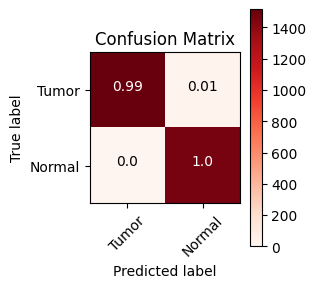

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, x_test, y_test):
    # Accuracy Score
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(test_yCl, axis=1)
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Accuracy: {accuracy}")

    # Precision Score
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"Precision: {precision}")

    # Recall Score
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"Recall: {recall}")

    # F1 Score
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"F1-Score: {f1}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    classes = ["Tumor","Normal"]
    plot_confusion_matrix(cm, classes, title='Confusion Matrix')

# Modeli değerlendir
evaluate_model(model, x_test, y_test)
